<a href="https://colab.research.google.com/github/asad200/BERT_MultiClass_Intent_Classification/blob/main/BERT_MultiClass_Intent_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Oct 20 11:40:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null

In [3]:
!pip install --upgrade grpcio >> /dev/null

In [4]:
!pip install tqdm >> /dev/null

In [5]:
!pip install bert-for-tf2 >> /dev/null

In [6]:
!pip install sentencepiece >> /dev/null

In [7]:
import os
import math
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
# configure the plots
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLOR_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLOR_PALETTE))
rcParams['figure.figsize'] = 12, 8
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
# download the data
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 53.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 15.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 65.4MB/s]


In [10]:
# import the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('valid.csv')

In [11]:
# pre-processing
train = train.append(val).reset_index(drop=True)
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [12]:
train.shape

(13784, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


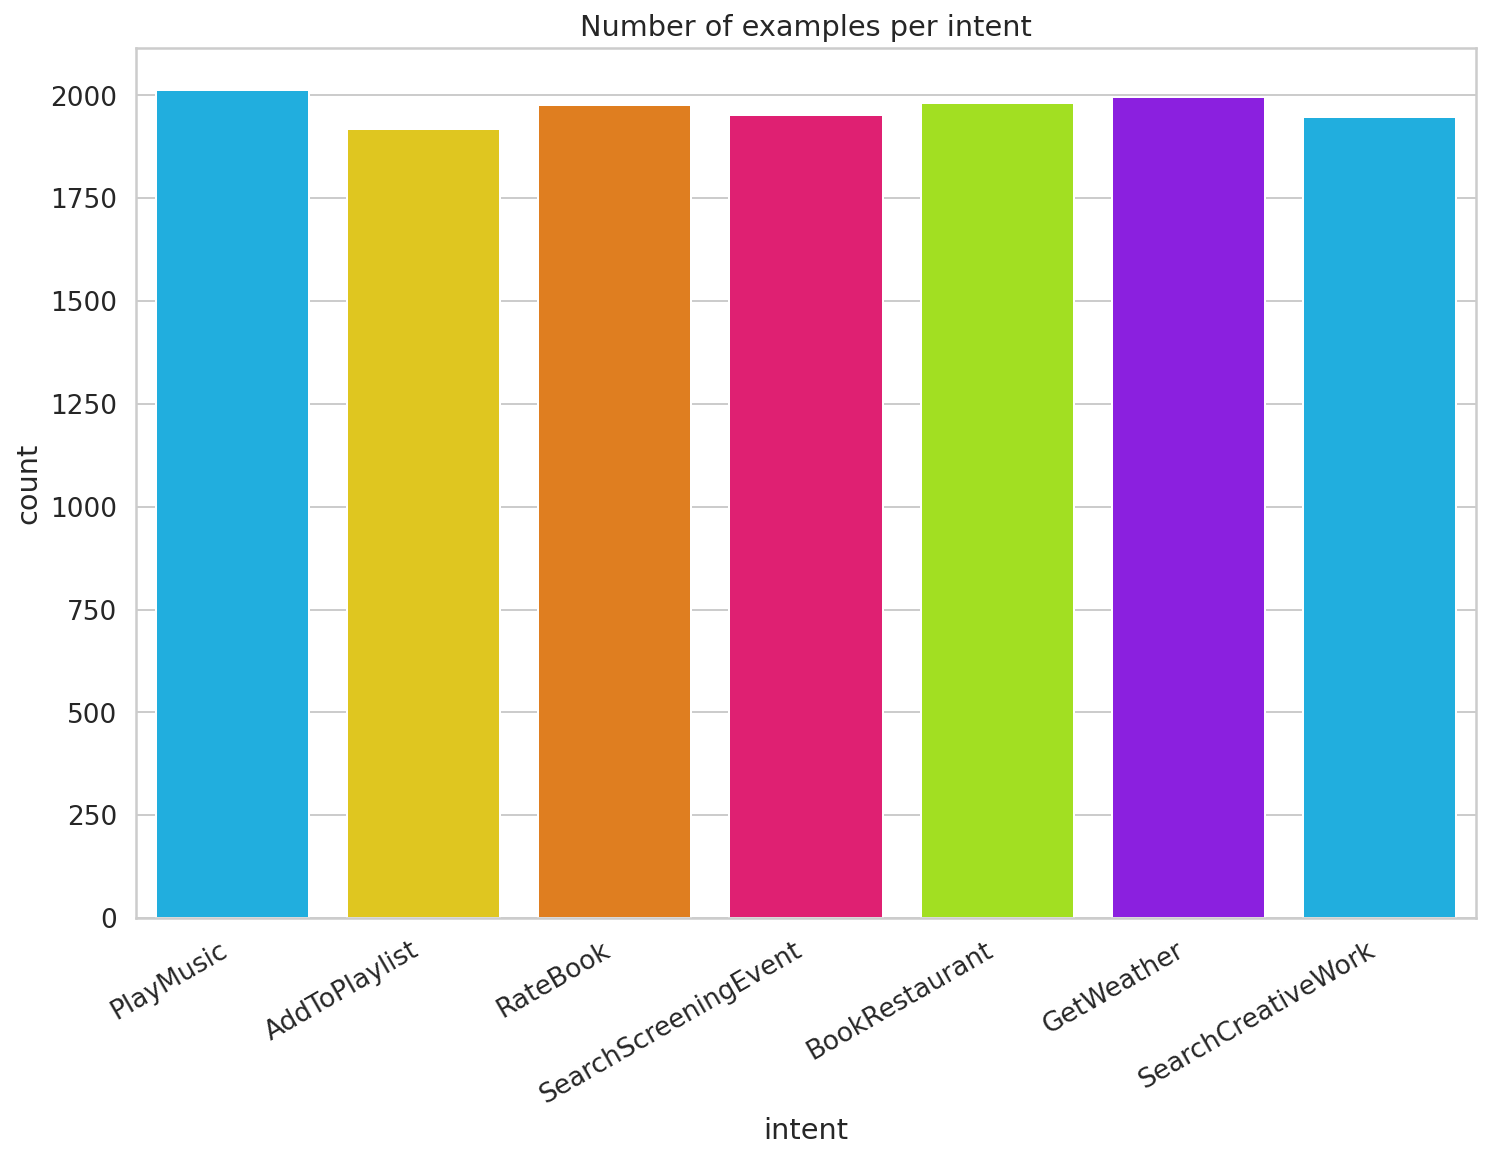

In [13]:
# plot the examples per intent
chart = sns.countplot(train.intent, palette=HAPPY_COLOR_PALETTE)
plt.title('Number of examples per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [14]:
# download the bert model
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-10-20 11:44:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   227MB/s    in 1.7s    

2020-10-20 11:44:19 (227 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [15]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [16]:
os.makedirs('model', exist_ok=True)

In [17]:
!mv uncased_L-12_H-768_A-12/ model

In [18]:
bert_model_name = 'uncased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join('model/', bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

In [19]:
bert_config_file

'model/uncased_L-12_H-768_A-12/bert_config.json'

In [21]:
# prepare the data by tekenizing and padding
class IntentRecognition:
  DATA_COL = 'text'
  LABEL_COL = 'intent'

  def __init__(self, train, test, tokenizer:FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.x_train, self.y_train), (self.x_test, self.y_test)) = map(self._prepare, [train, test])

    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.x_train, self.x_test = map(self._pad, [self.x_train, self.x_test])

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentRecognition.DATA_COL], row[IntentRecognition.LABEL_COL]

      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]

      # conver tokens to token ids (to numeric values)
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

      # get the max_seq_len
      self.max_seq_len = max(self.max_seq_len, len(token_ids))

      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for id in ids:
      cut_point = min(len(id), self.max_seq_len)
      id = id[:cut_point]
      id = id + [0] * (self.max_seq_len - len(id))
      x.append(id)

    return np.array(x)

In [22]:
# get the tokenizer from bert model
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'))

In [23]:
tokens = tokenizer.tokenize("this isn't a test!")
tokenizer.convert_tokens_to_ids(tokens)

[2023, 3475, 1005, 1056, 1037, 3231, 999]

In [27]:
# create the model by loading the bert model and extenting the classifiaction layer
def create_model(max_seq_len, bert_config_file, bert_ckpt_file):
  with tf.io.gfile.GFile(bert_config_file, 'r') as reader:
    bs = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bs)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name='bert')
    input_ids = tf.keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name='input_ids')
    bert_output = bert(input_ids)

    cls_out = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = tf.keras.layers.Dropout(0.5)(cls_out)
    logits = tf.keras.layers.Dense(units=768, activation='tanh')(cls_out)
    logits = tf.keras.layers.Dropout(0.5)(logits)
    outputs = tf.keras.layers.Dense(units=len(classes), activation='softmax')(logits)

    model = tf.keras.Model(inputs=input_ids, outputs=outputs)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

  return model

In [28]:
# process the data
classes = train.intent.unique().tolist()
data = IntentRecognition(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:04, 2843.73it/s]
700it [00:00, 2794.43it/s]


In [26]:
# initialize the model
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f790f1e5c88> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [29]:
data.x_train.shape

(13784, 38)

In [30]:
data.x_train[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [31]:
# compile the model using Adam optimizer 
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])


In [32]:
# train the model
log_dir = 'log/intent_detection' + datetime.datetime.now().strftime("%Y%m%d-%H%m%s")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    x=data.x_train,
    y=data.y_train,
    validation_split=0.1,
    batch_size=16,
    shuffle=True,
    epochs=5,
    callbacks=[tensorboard_callback]
    )

Epoch 1/5
  1/776 [..............................] - ETA: 0s - loss: 1.9402 - accuracy: 0.7500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
776/776 [==============================] - 478s 616ms/step - loss: 1.3071 - accuracy: 0.9769 - val_loss: 1.1801 - val_accuracy: 0.9993
Epoch 2/5
776/776 [==============================] - 471s 607ms/step - loss: 1.1815 - accuracy: 0.9985 - val_loss: 1.1785 - val_accuracy: 1.0000
Epoch 3/5
776/776 [==============================] - 469s 605ms/step - loss: 1.1773 - accuracy: 0.9988 - val_loss: 1.1773 - val_accuracy: 0.9964
Epoch 4/5
776/776 [==============================] - 469s 604ms/step - loss: 1.1745 - accuracy: 0.9979 - val_loss: 1.1791 - val_accuracy: 0.9949
Epoch 5/5
776/776 [==============================] - 464s 

In [ ]:
# model.save_weights('bert_weights_5epochs_9986.h5')

In [33]:
# evaluate the model
_, test_acc = model.evaluate(data.x_test, data.y_test)
print(test_acc)

22/22 [==============================] - 5s 235ms/step - loss: 1.1887 - accuracy: 0.9957
0.9957143068313599


In [34]:
predictions = model.predict(data.x_test).argmax(axis=-1)

In [36]:
# print the classification report
print(classification_report(data.y_test, predictions, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.99      0.98      0.98        86
       AddToPlaylist       1.00      1.00      1.00       124
            RateBook       0.99      1.00      0.99        80
SearchScreeningEvent       1.00      0.90      0.95       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       1.00      0.99      1.00       104
  SearchCreativeWork       0.89      0.98      0.93       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [37]:
# plot the hostory
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

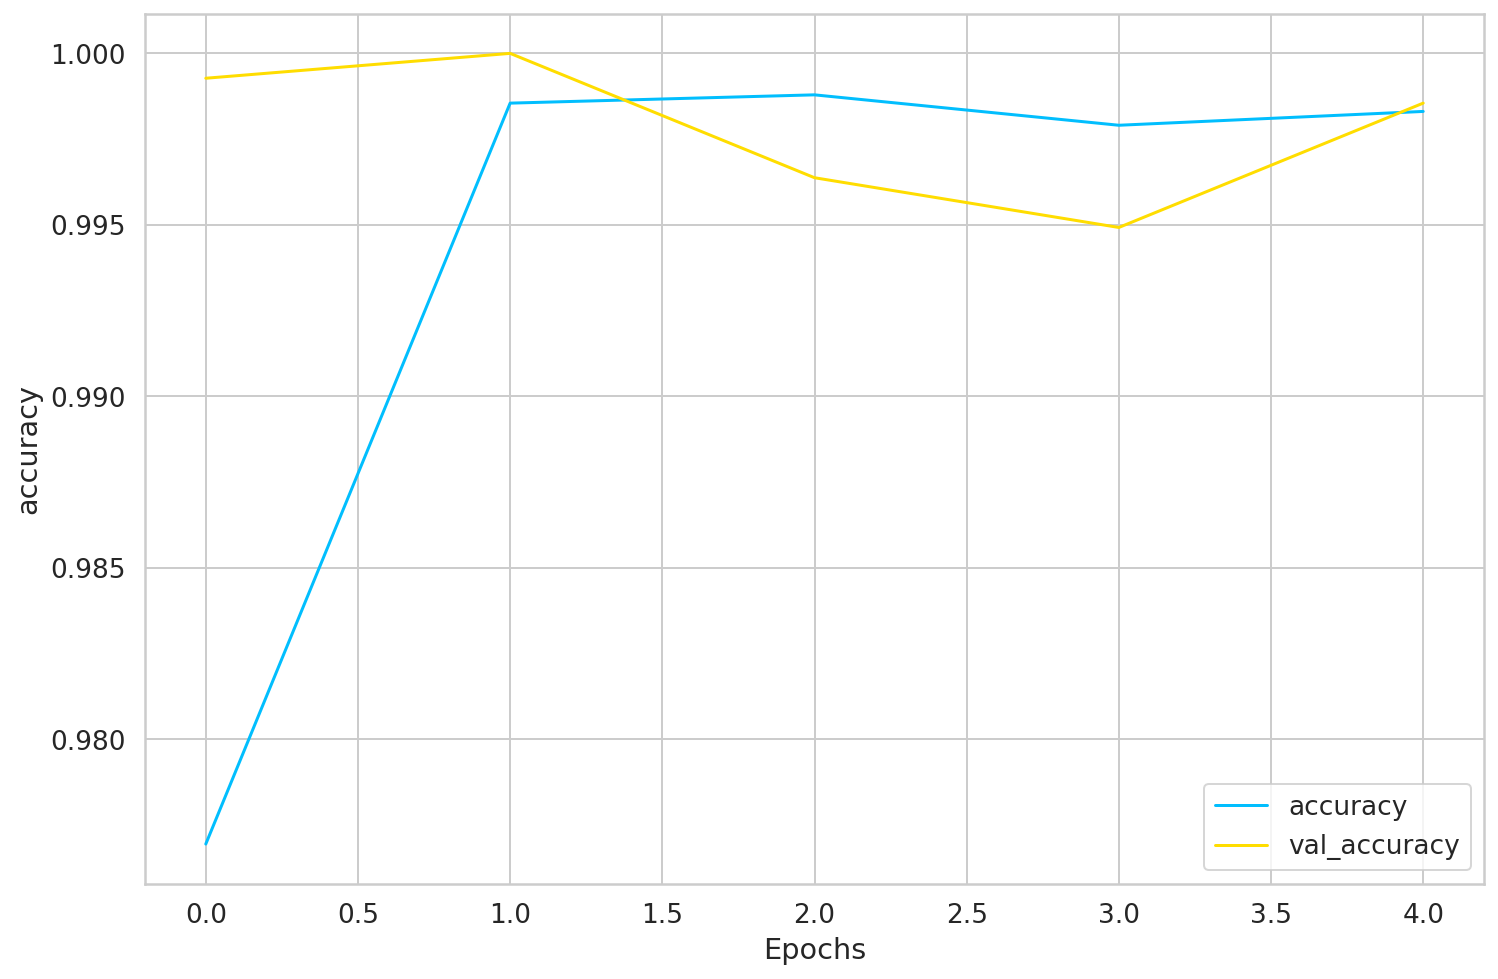

In [38]:
plot_graphs(history, 'accuracy')

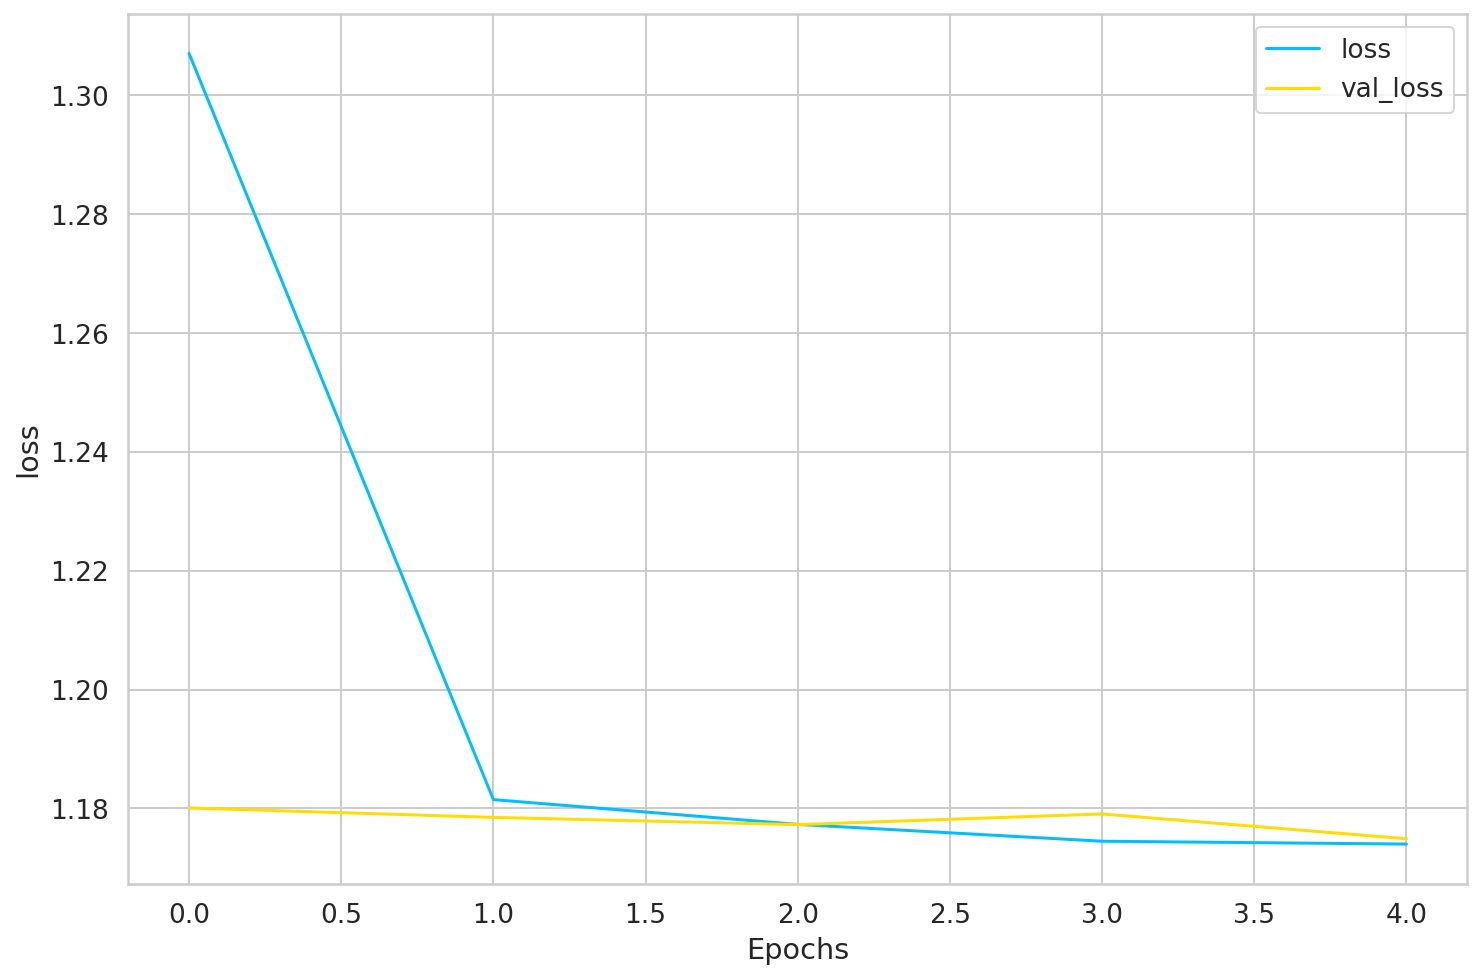

In [39]:
plot_graphs(history, 'loss')

In [40]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model.save('saved_model/my_model') 